### Permutation

The main operation of the router is the permutation of an input vector. The term permutation here is not used in its combinatorial meaning, but is defined below instead.

First of all, it should be pointed out that all the values on the MIDI bus are taken to be integers in the range $[0; 127]$. The input and the output of the permutation are vectors of values in this domain.

Before the permutation is derived, its desired characteristics should be clarified.
1. Number of input and output channels need not necessarily be equal.
2. All the input channels affect all the output channels to a certain degree.
3. The mapping should be continuous (in the discreet approximation, as we are operating in integers), so that close input vectors map to close output vectors.
4. The mapping should not be intuitively understandable by the musician. This implies that a permutation that maps all-zero input to all-zero output and/or all-maximum input to all-maximum output is unsatisfactory.
5. The output vector should not overflow.
6. The full range of each output channel should be covered by the input space. In other words, for each output channel for each possible value there exists at least one input vector that maps to an output vector that contains this value.
7. The state of the permutation should be gradually variable. This means that the permutation is parameterised, and changing the permutation parameter results in smooth changes in the output given the same input.

It should also be noted that the following properties are not specifically aimed for:
- Covering the entire output space is not required. Any specific output vector it is not guaranteed to be reachable.
- Unique mapping is not required. For any reachable output vector there might exist more than one input vector that maps to it.

All these requirements do not describe a single possible permutation. In the context of the musical device, a precise mathematical destination is probably not relevant. One permutation that fulfills the requirements is derived below, using some basic linear algebra and some intuitions.

To satisfy the first requirement, let's immediately consider the general case of $n$ input channels and $m$ output channels. The task is now to find a mapping from $n$ dimensional vector space to $m$ dimensional vector space.

\begin{equation}
\begin{bmatrix}i_{1} \\ i_{2} \\ ... \\ i_{n}\end{bmatrix}
\mapsto
\begin{bmatrix}o_{1} \\ o_{2} \\ ... \\ o_{m}\end{bmatrix}
\end{equation}

We begin with a linear mapping and introduce a matrix $P$ with $m$ rows and $n$ columns.  This satisfies the second requirement, as the element $p_{mn}$ of the matrix is a weigth with which $n$-th input contributes to $m$-th output.

\begin{equation}
\begin{bmatrix}p_{11} & p_{12} & ... & p_{1n} \\ p_{21} & ... \\ ... & & ... \\ p_{m1} & & & p_{mn}\end{bmatrix}
\times
\begin{bmatrix}i_{1} \\ i_{2} \\ ... \\ i_{n}\end{bmatrix}=
\begin{bmatrix}o_{1} \\ o_{2} \\ ... \\ o_{m}\end{bmatrix}
\end{equation}

Linear mapping also satisfies the third requirement: there are no abrupt jumps in output.

However, the fourth requirement, namely that the all-zero input should not map to all-zero output renders a linear mapping unsatisfactory. The fourth requirement calls for a translation. Let's introduce a translation vector that is added to the input vector before the multiplication by the matrix.

\begin{equation}
\begin{bmatrix}p_{11} & p_{12} & ... & p_{1n} \\ p_{21} & ... \\ ... & & ... \\ p_{m1} & & & p_{mn}\end{bmatrix}
\times
\left(
\begin{bmatrix}i_{1} \\ i_{2} \\ ... \\ i_{n}\end{bmatrix}
+
\begin{bmatrix}t_{1} \\ t_{2} \\ ... \\ t_{n}\end{bmatrix}
\right)=
\begin{bmatrix}o_{1} \\ o_{2} \\ ... \\ o_{m}\end{bmatrix}
\end{equation}

The fifth requirement is that the output doesn't overflow. Let's consider each output channel separately. The value of the $k$-th output channel is defined by the input vector and the $k$-th row of the matrix.

\begin{equation}
o_{k} = p_{k1} (i_{1} + t_{k}) + p_{k2} (i_{2} + t_{k}) + ... + p_{kn} (i_{n} + t_{k})
\end{equation}

Let's for the moment ignore the translation, or imagine that we somehow wrap the result of translation back to the domain, so that the vector that is multiplied by the matrix does not overflow.

By carefully picking the $p$ coeffiecients, it can be ensured that the output doesn't overflow. If the coefficients are in the range of $[0; 1]$ and the sum of the coefficients in a row equals $1$, than each coefficient is the percentage of contribution of the corresponding input. This means that every input channel affects any output channel only to a limit degree. No input channel can reach the full range of an output channel.

The fourth requirement is admittedly not precise, and yet it appears that in order to be more musically interesting, the control should be more redundant. Some input channels should be able to reach the full range of output, and some other input channels should be able to reverse the effect of the former channels.

So the internal calculations are performed in a broader domain. The translation and multiplication results are allowed to overflow the MIDI boundaries. The multiplication product is mapped back to the domain afterwards.

\begin{equation}
wrap
\left(
\begin{bmatrix}p_{11} & p_{12} & ... & p_{1n} \\ p_{21} & ... \\ ... & & ... \\ p_{m1} & & & p_{mn}\end{bmatrix}
\times
\left(
\begin{bmatrix}i_{1} \\ i_{2} \\ ... \\ i_{n}\end{bmatrix}
+
\begin{bmatrix}t_{1} \\ t_{2} \\ ... \\ t_{n}\end{bmatrix}
\right)
\right)=
\begin{bmatrix}o_{1} \\ o_{2} \\ ... \\ o_{m}\end{bmatrix}
\end{equation}

We need to employ such a way of wrapping that respects the continuity requirement. Wrapping using a modulo operation does not fulfill this requirment, as it involves a jump from one boundary to the other:

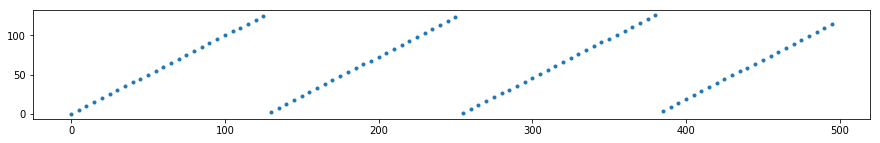

In [3]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(0, 500, 5)
y = x % 127

fig, ax = plt.subplots(figsize=(15, 2))
ax.plot(x, y, '.')
plt.show()

Instead of making a jump, the value could bounce from the boundary and starts moving in the opposite direction:

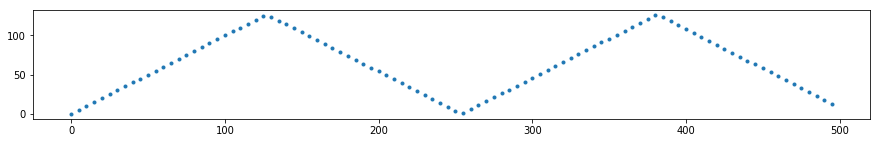

In [2]:
def wrap(x, limit):
    '''The lower limit is assumed to be 0.'''
    x %= 2 * limit
    if x > limit:
        x = 2 * limit - x
    return x

y = np.array([wrap(xi, 127) for xi in x])

fig, ax = plt.subplots(figsize=(15, 2))
ax.plot(x, y, '.')
plt.show()

Wrapping is applied to each element of the output vector.

With wrapping, the elements of the matrix can be picked almost arbitrarily.

However, it is desirable that input covers the output range more than once. The value of a coefficient can be understood as the number of times an input channel covers an output channel (ignoring translation). Large values of coefficients decrease the resolution of the input controls, which is to be avoided. Intuitively, the values of the coefficients should remain approximately  in the range $[-2, 2]$, where negative coefficients mean inversion of the input channel.

Also by intuition, the elements of the translation vector are in the MIDI domain.

The remaining requirement is that the permutation should be parameterized. This is detailed in a later section.